In [172]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL as pil
import os

**HPARAMS**

In [173]:
BATCH_SIZE = 1024

In [174]:
IMG_SIZE = (64, 64)

**Load Data**

In [175]:
DATA_DIR = "dataset"

In [176]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 16892 files belonging to 4 classes.
Using 13514 files for training.


In [177]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 16892 files belonging to 4 classes.
Using 3378 files for validation.


In [178]:
class_names = train_ds.class_names
print(class_names)

['black', 'blue', 'green', 'yellow']


**Visualize Data**

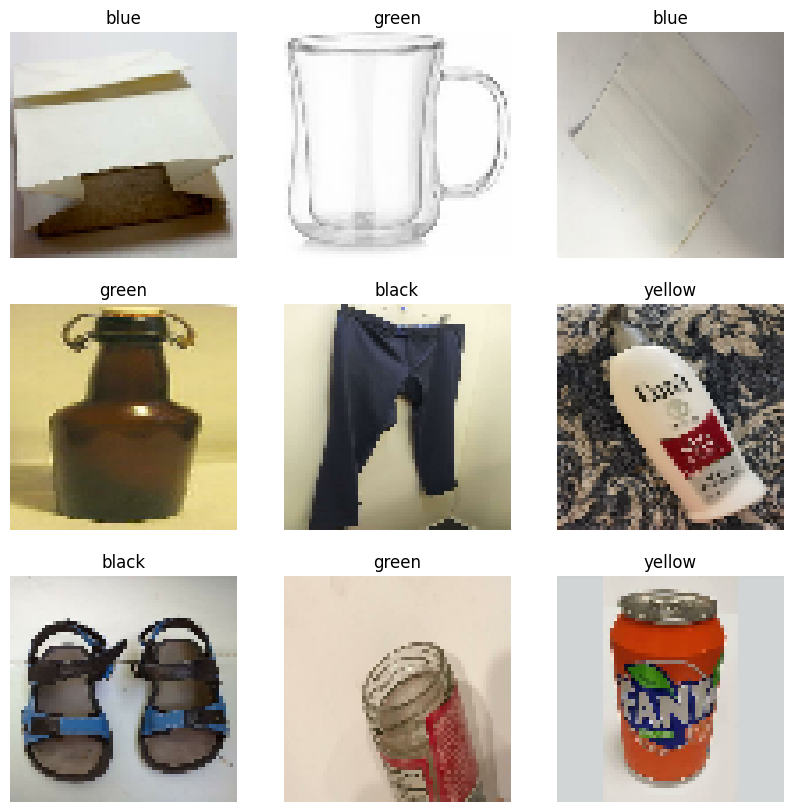

In [179]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [180]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(1024, 64, 64, 3)
(1024,)


**Preprocess Data**

In [181]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

In [182]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.07745098 0.9607844


In [183]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Utilitary**

In [184]:
def path_exists(path: str) -> str:
    if os.path.exists(path):
        i = 0
        while True:
            new_path = f"{path}_{i}"
            if not os.path.exists(new_path):
                return new_path
            i += 1
    return path

**Model**

In [185]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(64, 64, 3)))

# Conv & pooling tf.keras.layers
model.add(tf.keras.layers.Conv2D(8, (3, 3), activation='tanh', padding='same'))
model.add(tf.keras.layers.Conv2D(8, (3, 3), activation='tanh', padding='same'))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', padding='same'))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', padding='same'))
model.add(tf.keras.layers.MaxPool2D())

# Fully connected tf.keras.layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [186]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [187]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 8)         224       
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 8)         584       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                

In [196]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=26,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
                     tf.keras.callbacks.TensorBoard(log_dir=f"{path_exists('tensorlogs/logs')}")])
loss, accuracy = model.evaluate(val_ds)
model.save(f"models/model_loss_{loss}_acc_{accuracy}.h5")

Epoch 1/26
14/14 [==============================] - 36s 3s/step - loss: 0.4873 - accuracy: 0.8258 - val_loss: 0.8549 - val_accuracy: 0.6969
Epoch 2/26
14/14 [==============================] - 35s 2s/step - loss: 0.4498 - accuracy: 0.8425 - val_loss: 0.8659 - val_accuracy: 0.7040
Epoch 3/26
14/14 [==============================] - 35s 3s/step - loss: 0.4355 - accuracy: 0.8495 - val_loss: 0.8243 - val_accuracy: 0.7117
Epoch 4/26
14/14 [==============================] - 34s 2s/step - loss: 0.4033 - accuracy: 0.8646 - val_loss: 0.8358 - val_accuracy: 0.7111
Epoch 5/26
14/14 [==============================] - 35s 3s/step - loss: 0.3888 - accuracy: 0.8711 - val_loss: 0.8678 - val_accuracy: 0.7043
Epoch 6/26
4/4 [==============================] - 3s 583ms/step - loss: 0.8825 - accuracy: 0.6945


**Testing Model**

In [193]:
model = tf.keras.models.load_model("models/model_loss_0.9023550748825073_acc_0.6666666865348816.h5")

In [194]:
img = pil.Image.open("testing/banane.jpg").resize(IMG_SIZE)
img = np.array(img)

In [195]:
predictions = model.predict(img[None, :, :]).argmax(axis=1)

1/1 [==============================] - 0s 72ms/step


In [192]:
predictions

array([2], dtype=int64)